In [1]:
import os
import json
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# -------------------------------
# Config
# -------------------------------
MODELS_DIR = os.path.join("..", "models")
TASK4_RESULTS_FILE = os.path.join(MODELS_DIR, "task4_outputs", "task4_results.json")

BACKTEST_START = "2024-08-01"
BACKTEST_END = "2025-07-31"
BENCHMARK_WEIGHTS = {"SPY": 0.6, "BND": 0.4}  # 60/40 benchmark

In [2]:
# -------------------------------
# Load Task 4 optimal portfolio (Max Sharpe)
# -------------------------------
if not os.path.exists(TASK4_RESULTS_FILE):
    raise FileNotFoundError(f"Task 4 results not found at {TASK4_RESULTS_FILE}")

with open(TASK4_RESULTS_FILE, "r") as f:
    task4_results = json.load(f)

opt_weights = task4_results["max_sharpe"]["weights"]
tickers_used = list(opt_weights.keys())

print("Loaded optimal weights from Task 4 (Max Sharpe):")
print(opt_weights)

Loaded optimal weights from Task 4 (Max Sharpe):
{'BND': 0.5173, 'SPY': 0.4827}


In [6]:
# -------------------------------
# Load historical data for backtest period
# -------------------------------
all_tickers = list(set(tickers_used) | set(BENCHMARK_WEIGHTS.keys()))
print(f"Fetching historical data for: {', '.join(all_tickers)}")
prices = yf.download(all_tickers, start=BACKTEST_START, end=BACKTEST_END)["Close"].dropna()

# Compute daily returns
returns = prices.pct_change().dropna()

C:\Users\hp\AppData\Local\Temp\ipykernel_30300\678824.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(all_tickers, start=BACKTEST_START, end=BACKTEST_END)["Close"].dropna()
[                       0%                       ]

[*********************100%***********************]  2 of 2 completed

Fetching historical data for: BND, SPY


In [7]:
# -------------------------------
# Strategy: initial allocation from Task 4 (no rebalancing)
# -------------------------------
opt_w_series = pd.Series(opt_weights)
# Ensure weights align with DataFrame columns
opt_returns = (returns[opt_w_series.index] * opt_w_series).sum(axis=1)

# Benchmark: 60% SPY / 40% BND
bench_w_series = pd.Series(BENCHMARK_WEIGHTS)
bench_returns = (returns[bench_w_series.index] * bench_w_series).sum(axis=1)

In [8]:
# -------------------------------
# Compute cumulative performance
# -------------------------------
opt_cum = (1 + opt_returns).cumprod()
bench_cum = (1 + bench_returns).cumprod()

# -------------------------------
# Compute Sharpe Ratios & Total Returns
# -------------------------------
TRADING_DAYS = 252
def sharpe_ratio(r):
    return (r.mean() / r.std()) * np.sqrt(TRADING_DAYS)

metrics = {
    "Strategy": {
        "Total Return": opt_cum.iloc[-1] - 1,
        "Sharpe Ratio": sharpe_ratio(opt_returns)
    },
    "Benchmark": {
        "Total Return": bench_cum.iloc[-1] - 1,
        "Sharpe Ratio": sharpe_ratio(bench_returns)
    }
}


Performance Metrics (Backtest Period):
Strategy: Total Return = 10.68%, Sharpe = 1.053
Benchmark: Total Return = 12.47%, Sharpe = 1.021


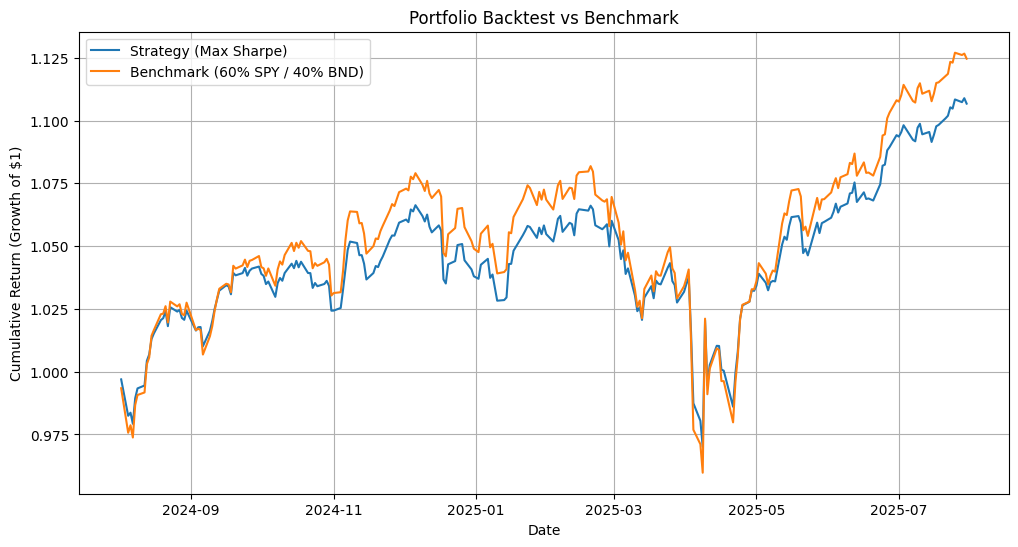

In [9]:
print("\nPerformance Metrics (Backtest Period):")
for k, v in metrics.items():
    print(f"{k}: Total Return = {v['Total Return']:.2%}, Sharpe = {v['Sharpe Ratio']:.3f}")

# -------------------------------
# Plot performance
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(opt_cum, label="Strategy (Max Sharpe)")
plt.plot(bench_cum, label="Benchmark (60% SPY / 40% BND)")
plt.title("Portfolio Backtest vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Growth of $1)")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# -------------------------------
# Save results
# -------------------------------
out_dir = os.path.join(MODELS_DIR, "task5_outputs")
os.makedirs(out_dir, exist_ok=True)

results = {
    "backtest_start": BACKTEST_START,
    "backtest_end": BACKTEST_END,
    "strategy_weights": opt_weights,
    "benchmark_weights": BENCHMARK_WEIGHTS,
    "metrics": metrics
}

results_file = os.path.join(out_dir, "task5_results.json")
with open(results_file, "w") as f:
    json.dump(results, f, indent=2)

print(f"\nSaved Task 5 backtest results to: {results_file}")


Saved Task 5 backtest results to: ..\models\task5_outputs\task5_results.json
